# Supervised Project: Stroke Prediction

## Table of Contents

**[1. Introduction](#introduction)**

[1.1 Import libraries](#import) 

[1.2 Data informations](#data)


**[2. Exploratory Data Analysis](#exploratory)**

[2.1 Distribution of target](#distribution)

[2.2 Univariate analysis of continuous variables](#univariate)

[2.3 Univariate analysis of categorical variables](#univariate_a)

[2.4 Visualization of the correlations between features](#visualization)


**[3. Feature Engineering and Selection](#feature)**

[3.1 Feature Engineering](#feature_e)

[3.2 Feature Selection](#feature_s)

[3.3 Remove Collinear Features](#remove)


**[4. Split dataset and Models Selection](#split)**

[4.1 Imputing missing values](#imputing)

[4.2 Establish a baseline](#establish)

[4.3 Training and test Sets](#training)

[4.4 Deal with imbalance data with SMOTE and RandomUnderSampler](#deal)

[4.5 Models comparison](#models)


**[5. Perform Hyperparameter Tuning on the Best Model](#perform)**

[5.1 Hyperparameter tuning of the logisticregression model and evaluation](#hyper)

[5.2 Hyperparameter tuning of the GradientBoosting model and evaluation](#hyperp)

[5.3 Hyperparameter tuning of SVM model and evaluation](#hyperpa)


**[6. Conclusion](#conclusion)**

<a id='introduction'></a>
## 1. Introduction
Acoording to the World Health Organization, stoke is the second leading cause of death globally, responsible for approximately 11% of total deaths. If stroke can be predicted, we can do better to prevent stroke. In this notebook, I will explore the relationships between various physical conditions,habits to strokes, then predict the stroke probability with the machine learning model.

<a id='import'></a>
### 1.1 Import Libraries

In [1018]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# machine learning model related
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix
from sklearn.pipeline import Pipeline

# model algorithams
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# method to deal with unbalanced data
import imblearn

plt.style.use('ggplot')

<a id='data'></a>
### 1.2 Data Information

In [1073]:
# Load data
data = pd.read_csv('C:/Users/xiaoj/Downloads/healthcare-dataset-stroke-data.csv',index_col = 'id')
data.head().T

id,9046,51676,31112,60182,1665
gender,Male,Female,Male,Female,Female
age,67,61,80,49,79
hypertension,0,0,0,0,1
heart_disease,1,0,1,0,0
ever_married,Yes,Yes,Yes,Yes,Yes
work_type,Private,Self-employed,Private,Private,Self-employed
Residence_type,Urban,Rural,Rural,Urban,Rural
avg_glucose_level,228.69,202.21,105.92,171.23,174.12
bmi,36.6,NaN,32.5,34.4,24
smoking_status,formerly smoked,never smoked,never smoked,smokes,never smoked


In [1020]:
# Check the information of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


In [1021]:
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [1022]:
# Check the unique values of categorical variables
category =['gender', 'ever_married', 'work_type','Residence_type','smoking_status']
[data[x].value_counts() for x in category]

[Female    2994
 Male      2115
 Other        1
 Name: gender, dtype: int64,
 Yes    3353
 No     1757
 Name: ever_married, dtype: int64,
 Private          2925
 Self-employed     819
 children          687
 Govt_job          657
 Never_worked       22
 Name: work_type, dtype: int64,
 Urban    2596
 Rural    2514
 Name: Residence_type, dtype: int64,
 never smoked       1892
 Unknown            1544
 formerly smoked     885
 smokes              789
 Name: smoking_status, dtype: int64]

As we can see, there are three types in gender, including female, male and other. Since there are only one 'other', I will delete this data.

In [1023]:
# Delete the 'other' in 'gender'
data = data[data['gender']!='Other']

In [1024]:
# Transfer all categorical features including two categories into numerical features
data['ever_married'] = (data['ever_married']== 'Yes').astype(np.int)

data['Residence_type'] = (data['Residence_type'] == 'Urban').astype(np.int)

data['gender'] = (data['gender']== 'Male').astype(np.int)

In [1025]:
# Check the statistical information of numerical variables
round(data.describe(exclude = ['object','int64','int32']),4)

,age,avg_glucose_level,bmi
count,5109.0000,5109.0000,4908.0000
mean,43.2300,106.1404,28.8946
std,22.6136,45.2850,7.8543
min,0.0800,55.1200,10.3000
25%,25.0000,77.2400,23.5000
50%,45.0000,91.8800,28.1000
75%,61.0000,114.0900,33.1000
max,82.0000,271.7400,97.6000


From the initial information, there are no obvious outliers.

### Initial Insights about Dataset
1. There are 12 features in the dataset. Since the "id" didn't have any influence on the final prediction, I excluded and used it as index. Finally there are 11 features in the dataset.


2. Only 'bmi' feature has missing values,total 201.


3. Both categorical and numerical features are present.
    - **Categorical Features**(2):'work_type','smoking_status'   
    
    - **Binary Numerical Features**(6): 'ever_married', 'Residence_type', 'hypertension', 'heart_disease','gender', 'stroke'   
      
    - **Continuous Numerical Features**(3):'age', 'avg_glucose_level', 'bmi' 

<a id='exploratory'></a>
## 2. Exploratory Data Analysis¶

<a id='distribution'></a>
### 2.1 Distribution of target

In [1026]:
# The target here is 'stroke', which is a classification variable. Let's check its categories and corresponding counts
stroke_count = pd.DataFrame(data['stroke'].value_counts())

# add a new column to show the ratio of the two categories
stroke_count['ratio'] = stroke_count['stroke']/(stroke_count['stroke'].sum())

# replace '0' and '1' with 'healthy' and 'stroke'
stroke_count = stroke_count.rename(index = {0:'healthy',1:'stroke'})

stroke_count

,stroke,ratio
healthy,4860,0.951262
stroke,249,0.048738


(0.0, 5300.0)

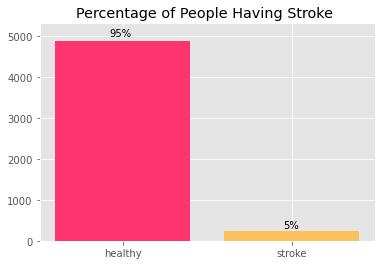

In [1027]:
# Visualization of distribution of target
fig, ax = plt.subplots(figsize = (6,4))
colors = ['#fe346e','#FBC15E']

ax.bar(stroke_count.index,stroke_count['stroke'],color=colors)
plt.text(-0.08,5000, '95%')
plt.text(0.95,300, '5%')
plt.title('Percentage of People Having Stroke ')
plt.ylim(0,5300)

It can be found that there are only 5 people of 100 people will have stroke in out sample data. **The data is highly unbalanced.** So, when tuning hyperparameter,modeling and training data, we should add some parameters specific for imbalance to best solve this problem.

<a id='univariate'></a>
### 2.2 Univariate analysis of continuous variables

Text(40, 0.04, "Stroke patients' age distribution")

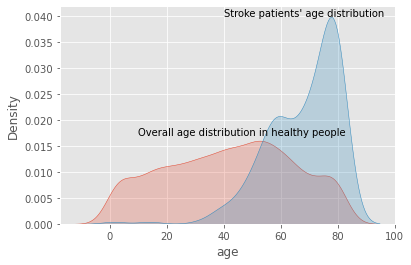

In [1028]:
# Let's firstly perform the univariate analysis of continuous variables-age
# Overall Age distribution  
sns.kdeplot(x = 'age', data=data[data['stroke']==0], shade = True)
plt.text(10,0.017, 'Overall age distribution in healthy people')

# Stroke patient age distribution
sns.kdeplot(x= 'age',data=data[data['stroke']==1], shade = True)
plt.text(40,0.040, "Stroke patients' age distribution")

In [1029]:
# define a function to calculate the numbers of people who are healthy or got stroke in continuous features
# copy the original dataset
data1 = data.copy()

def group(subdata):
    # to make it more clear, I bin the continuous features into labels
    labels=['Children', 'Teenager', 'Adults', 'Mid Adults', 'Elders']
    data1['age_label'] = pd.cut(subdata['age'], bins=[0., 12., 18., 50., 67., 100.], labels=['Children', 'Teenager', 'Adults', 'Mid Adults', 'Elders'])
    pd.options.mode.chained_assignment = None 
    group_counts = data1['age_label'].value_counts()
    
    # To plot the age categories and corresponding counts. And using the size of the points to show the numbers size
    sns.scatterplot(x = group_counts.index,y = group_counts.values, s = group_counts.values / 5, ax = ax[0])
    
    # Add the number for each points
    
    for name,value in zip(group_counts.index, group_counts.values):
        ax[0].text(labels.index(name)+0.11, value+15, value,{'size':8})   
    
    ax[0].set_title('How Age Impact on Having Stroke')
    ax[0].set_xlim(-0.2,4.4)
    ax[0].set_ylim(-70,2200)
    ax[0].set_ylabel('Counts')
    ax[0].set_xlabel('Ages')
   

# define a function to show the ratio of health and stroke in different labels
def ratio_in_label(labels):    
    label_stroke = (data1.groupby([labels, 'stroke']).count()*100 / data1.groupby(labels).count()).unstack()
    plots = label_stroke['age'].sort_values(by=1).plot.barh(stacked = True, color = colors,ax=ax[1])
    
    for rect in plots.patches:
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()    
        # The height of the bar is the data value and can be used as the label
        label_text = f'{width:.2f}%'  # f'{width:.2f}' to format decimal values
        # ax.text(x, y, text)
        label_x = x + width / 2
        label_y = y + height / 2 
        # only plot labels greater than given width
        if width > 0:
            plots.text(label_x, label_y, label_text, ha='center', va='center', fontsize=10)
    ax[1].set_yticklabels(ax[1].get_yticklabels(), rotation=60, fontsize=10)
    ax[1].set_title('Ratio of Healthy and Stroke People in Diverse categories of  '+ labels[0:-6],size=12)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('Ratio of Stroke and Health People')
    plt.legend(loc='center left', bbox_to_anchor=(0, 0.8))

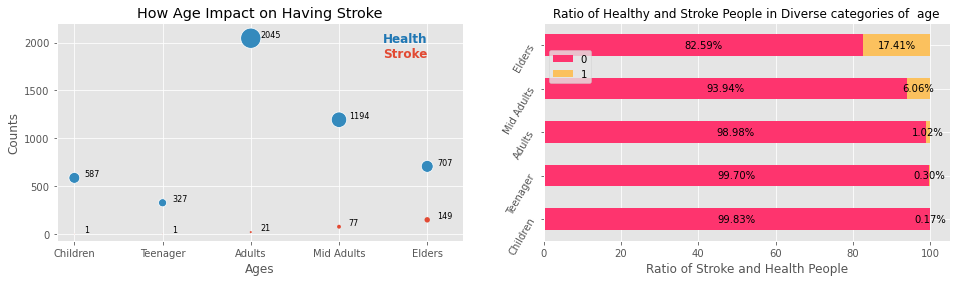

In [1030]:
fig,ax = plt.subplots(1,2,figsize = (16,4))

# Check how many peoples have stroke in each groups 
age_stroke = group(data1[data1['stroke'] == 1])
ax[0].text(3.5,1850,'Stroke',{'color':'#E24A33','weight':'bold','size':12})

# Check how many peoples are healthy in each groups 
age_health = group(data1[data1['stroke'] == 0])
ax[0].text(3.5,2000,'Health',{'color':'#1f77b4','weight':'bold','size':12})

# check the ratio of health and stroke people in different ages.
data1['age_label'] = pd.cut(data1['age'], bins=[0., 12., 18., 50., 67., 100.], labels=['Children', 'Teenager', 'Adults', 'Mid Adults', 'Elders'])
ratio_in_label('age_label')

Text(80, 0.04, "Stroke patients' glucose distribution")

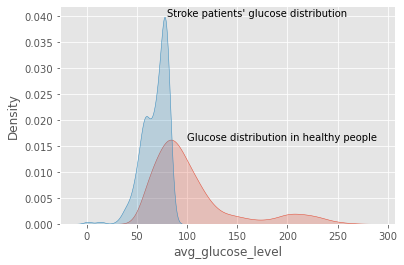

In [1031]:
# Let's move to the second continuous variable-'avg_glucose_level', and do the univariate analysis
# Overall glucose_level distribution  
sns.kdeplot(x = 'avg_glucose_level', data = data1[data1['stroke']== 0], shade = True)
plt.text(100,0.016, 'Glucose distribution in healthy people')

# Stroke patient glucose distribution
sns.kdeplot(x= 'age',data=data1[data1['stroke']==1], shade = True)
plt.text(80,0.040, "Stroke patients' glucose distribution")

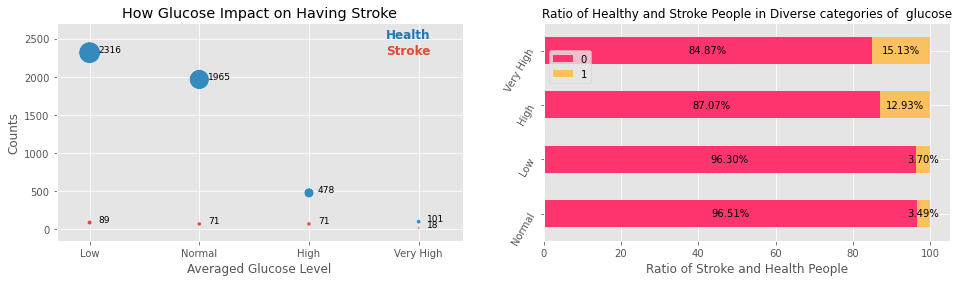

In [1032]:
# Same with age, I divide glucose into several groups
# define a function to divide glucose into several levels, and counts corresponding numbers, then plot them 
fig,ax = plt.subplots(1,2,figsize = (16,4))
def group(subdata):
    labels=['Low', 'Normal', 'High', 'Very High']
    data1['glucose_label'] = pd.cut(subdata['avg_glucose_level'], bins=[0., 90., 160., 230., 300.], labels=['Low', 'Normal', 'High', 'Very High'])
    group_counts = data1['glucose_label'].value_counts()
    
    # To plot the age categories and corresponding counts. And using the size of the points to show the numbers size
    sns.scatterplot(x = group_counts.index,y = group_counts.values, s = group_counts.values / 5,ax = ax[0])
    
    # Add the number for each points
    for name,value in zip(group_counts.index, group_counts.values):
        ax[0].text(labels.index(name)+0.08, value+10, value,{'size':9})   
    
    ax[0].set_title('How Glucose Impact on Having Stroke')
    ax[0].set_xlim(-0.3,3.4)
    ax[0].set_ylim(-150,2700)
    ax[0].set_ylabel('Counts')
    ax[0].set_xlabel('Averaged Glucose Level')
   
# Check how many peoples have stroke in each groups 
glucose_stroke = group(data1[data1['stroke'] == 1])
ax[0].text(2.7,2300,'Stroke',{'color':'#E24A33','weight':'bold','size':12})

# Check how many peoples are healthy in each groups 
glucose_health = group(data1[data1['stroke'] == 0])
ax[0].text(2.7,2500,'Health',{'color':'#1f77b4','weight':'bold','size':12})

# check the ratio of health and stroke people with different glucose levels.
data1['glucose_label'] = pd.cut(data1['avg_glucose_level'], bins=[0., 90., 160., 230., 300.], labels=['Low', 'Normal', 'High', 'Very High'])
ratio_in_label('glucose_label')

Text(33, 0.04, "Stroke patients' BMI distribution")

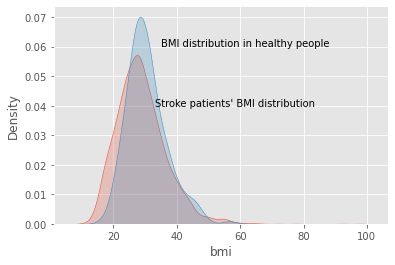

In [1033]:
# Now I will perform the last continuous variable's analysis
# Overall BMI distribution  
sns.kdeplot(x = 'bmi', data = data1[data1['stroke']== 0], shade = True)
plt.text(35,0.06, 'BMI distribution in healthy people')

# Stroke patient glucose distribution
sns.kdeplot(x= 'bmi',data=data1[data1['stroke']==1], shade = True)
plt.text(33,0.04, "Stroke patients' BMI distribution")

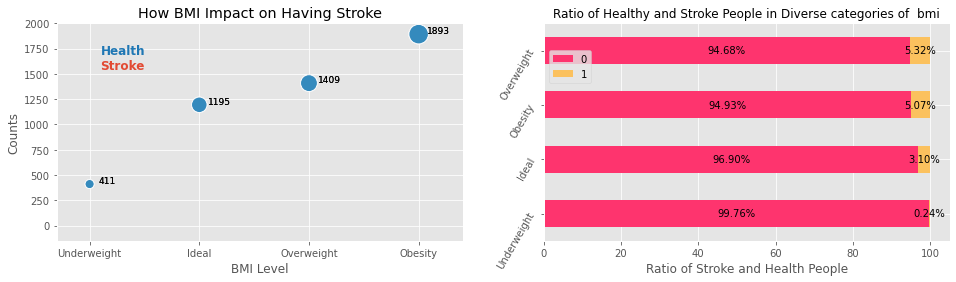

In [1034]:
# Same with age, I divide glucose into several groups
# define a function to divide glucose into several levels, and counts corresponding numbers, then plot them 
fig,ax = plt.subplots(1,2,figsize = (16,4))

def group(subdata):
    labels=['Underweight', 'Ideal', 'Overweight', 'Obesity']
    data1['bmi_label'] = pd.cut(data1['bmi'], bins=[0., 19., 25., 30.,100.], labels=['Underweight', 'Ideal', 'Overweight', 'Obesity'])
    group_counts = data1['bmi_label'].value_counts()
    
    # To plot the age categories and corresponding counts. And using the size of the points to show the numbers size
    sns.scatterplot(x = group_counts.index,y = group_counts.values, s = group_counts.values / 5, ax = ax[0])
    
    # Add the number for each points
    for name,value in zip(group_counts.index, group_counts.values):
        ax[0].text(labels.index(name)+0.08, value+10, value,{'size':9})   
    
    ax[0].set_title('How BMI Impact on Having Stroke')
    ax[0].set_xlim(-0.3,3.4)
    ax[0].set_ylim(-150,2000)
    ax[0].set_ylabel('Counts')
    ax[0].set_xlabel('BMI Level')
   
# Check how many peoples have stroke in each groups 
bmi_stroke =  group(data1[data1['stroke'] == 1])
ax[0].text(0.1,1550,'Stroke',{'color':'#E24A33','weight':'bold','size':12})

# Check how many peoples are healthy in each groups 
bmi_health = group(data1[data1['stroke'] == 0])
ax[0].text(0.1,1700,'Health',{'color':'#1f77b4','weight':'bold','size':12})

# check the ratio of health and stroke people with different bmi values
data1['bmi_label'] = pd.cut(data1['bmi'], bins=[0., 19., 25., 30.,100.], labels=['Underweight', 'Ideal', 'Overweight', 'Obesity'])
ratio_in_label('bmi_label')

#### Continuous Variables Summary:
The dataset has three kinds of continuous features: 'age','glucose level','BMI'. Among these three features, I found:


1) All the distributions of these three features are not normal, eigher skewed or multidistribution;


2) To make it more readable, I binned these continuous feature, grouped and labeled them based on their range


3) All of three continuous features showed their great effects on 'stroke':
  - The older the people are, the higher risk to have strokes;
  
  
  - The higher the glucose level is, the more chance to get stroke.
  
  
  - The higher BMI is, higher possibility of having strokes.

4) There 3 continuous features should all be included in the model.

<a id='univeriate_a'></a>
### 2.3 Univeriate analysis of categorical variables

Now let's come to the categorical features, we have 3 categorical features and 5 binary numerical features, one of them is the target. I will try to find out what kind of realationship exist between categorical features and the target.

In [1035]:
# Define a function to collect 3 figures: 
# 1)the kde distribution of stroke by categorcial features
# 2) the counts of stroke by categorcal, 
# 3)ratio of stroke and healthy in diverse categories

def dis_coun_rat(categorical_feature):
    fig,ax = plt.subplots(1,3,figsize = (18,4),gridspec_kw={'width_ratios': [1.2, 1, 1.2]})
    colors = ['#fe346e','#FBC15E']
    
    # Distribution of stroke by categorical feature
    sns.kdeplot(x='stroke',data=data, hue=categorical_feature,ax = ax[0])
    ax[0].set_title('Distribution of Stroke by '+categorical_feature, size = 15)
    
    # Numbers of stroke by categorical feature
    group_feature = data.groupby([categorical_feature, 'stroke']).count().unstack()
    group_feature['age'].plot.bar(stacked = True, ax = ax[1],color = colors)
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=30, fontsize=10)
    ax[1].set_title(categorical_feature.capitalize()+' vs. Stroke',size=15)

    # Propability of stroke by gender
    gender_stroke = (data.groupby([categorical_feature, 'stroke']).count()*100 / data.groupby(categorical_feature).count()).unstack()
    plots = gender_stroke['age'].sort_values(by=1).plot.barh(stacked = True, color = colors, ax = ax[2])
    for rect in plots.patches:
    # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()    
        # The height of the bar is the data value and can be used as the label
        label_text = f'{width:.2f}%'  # f'{width:.2f}' to format decimal values
        # ax.text(x, y, text)
        label_x = x + width / 2
        label_y = y + height / 2 
        # only plot labels greater than given width
        if width > 0:
            plots.text(label_x, label_y, label_text, ha='center', va='center', fontsize=10)
    ax[2].set_yticklabels(ax[2].get_yticklabels(), rotation=60, fontsize=10)
    ax[2].set_title('Ratio of Stroke and Health People by '+categorical_feature,size=15)
    ax[2].set_ylabel('')
    ax[2].set_xlabel('Ratio of Stroke and Health in '+categorical_feature)
    plt.legend(loc='center left', bbox_to_anchor=(0, 0.8))


The chance of male to suffer stroke are 0.77 higher than that of female.


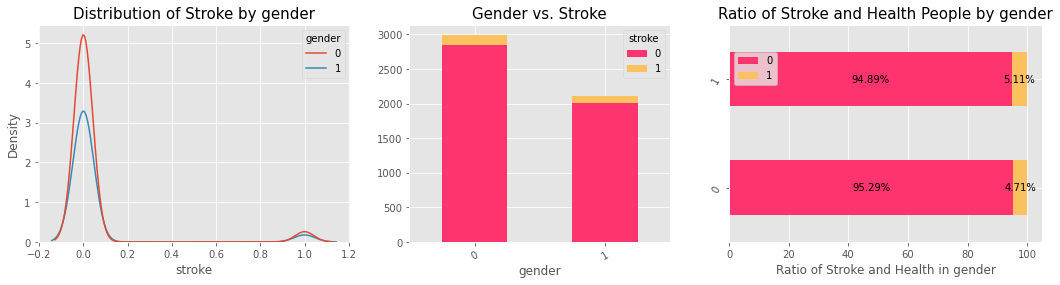

In [1036]:
# How 'gender' impact the stroke
dis_coun_rat('gender')

ratio_gender = data[(data['stroke']==1) & (data['gender']==1)]['age'].count()/data[(data['stroke']==1) & (data['gender']==0)]['age'].count()
print('\033[1m'+'The chance of male to suffer stroke are %0.2f higher than that of female.' %ratio_gender)

C:\Users\xiaoj\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


5% people who worked suffered stroke.


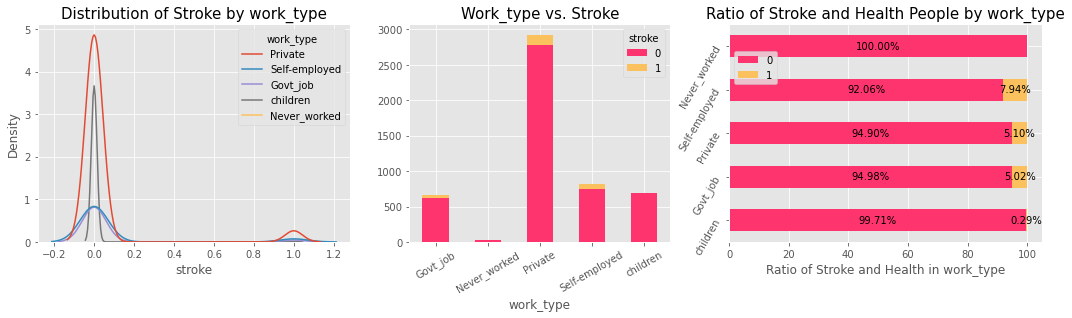

In [1037]:
# How 'work_type' impact the stroke
dis_coun_rat('work_type')

#  Since there are bacially no people who never worked got stroke. to simplify the question, I just calculate ratio of people who worked and got stroke
stroke_work = data[(data['stroke']==1) & (data['work_type']=='Self-employed')]['age'].count()+ data[(data['stroke']==1) & (data['work_type']=='Private')]['age'].count()+data[(data['stroke']==1) & (data['work_type']=='Govt_job')]['age'].count()
total_work = data[(data['work_type']!='Children') & (data['work_type'] != 'Never_worked')]['age'].count()
ratio_work = stroke_work / total_work
print('\033[1m'+'{0:.0%} people who worked suffered stroke.'.format(ratio_work))

The chance of people who smoke to suffer stroke are 1.24 higher than that of those who never smoke.


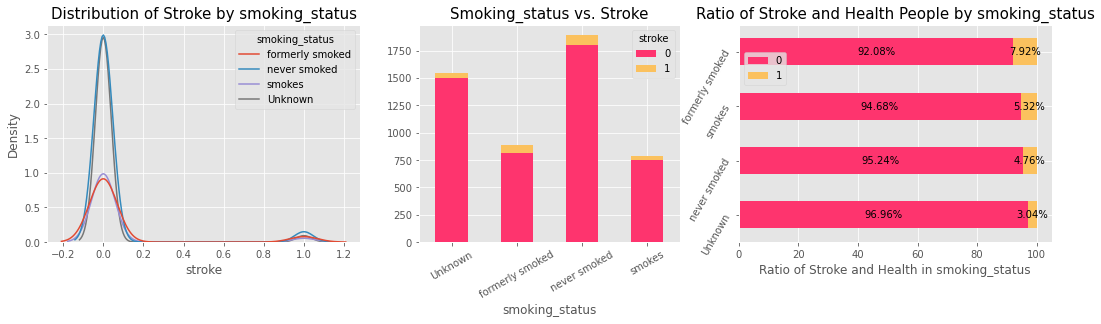

In [1038]:
# How 'smoking_status' impact the stroke
dis_coun_rat('smoking_status')

# To simplify the question, I will not consider people with 'unknown' smoking history
people_smoked = data[(data['stroke']==1) & (data['smoking_status']=='smokes')]['age'].count() + data[(data['stroke']==1) &(data['smoking_status']=='formerly smoked')]['age'].count()
people_no_smoked = data[(data['stroke']==1) & (data['smoking_status']=='never smoked')]['age'].count()
ratio_smoke = people_smoked / people_no_smoked
print('\033[1m'+'The chance of people who smoke to suffer stroke are %0.2f higher than that of those who never smoke.' %ratio_smoke)

The chance of people who ever married to suffer stroke are 7.59 higher than that of those without marriage.


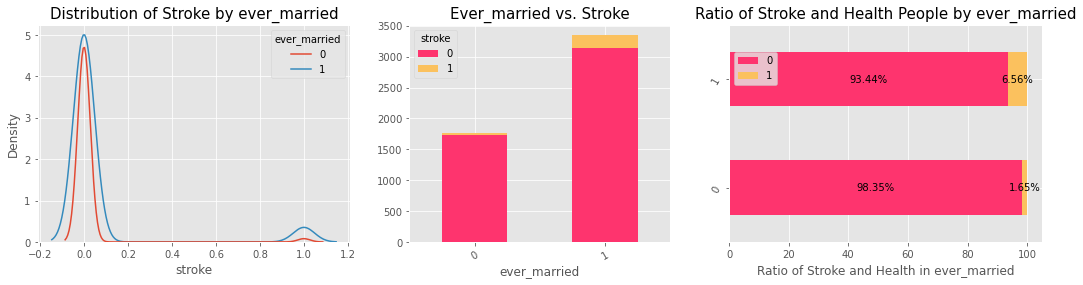

In [1039]:
# How 'married' impact the stroke
dis_coun_rat('ever_married')

ratio_married = data[(data['stroke']==1) & (data['ever_married']==1)]['age'].count()/data[(data['stroke']==1) & (data['ever_married']==0)]['age'].count()
print('\033[1m'+'The chance of people who ever married to suffer stroke are %0.2f higher than that of those without marriage.' %ratio_married)

The chance of people living in urban to suffer stroke are 0.84 higher than that of those who live in rural.


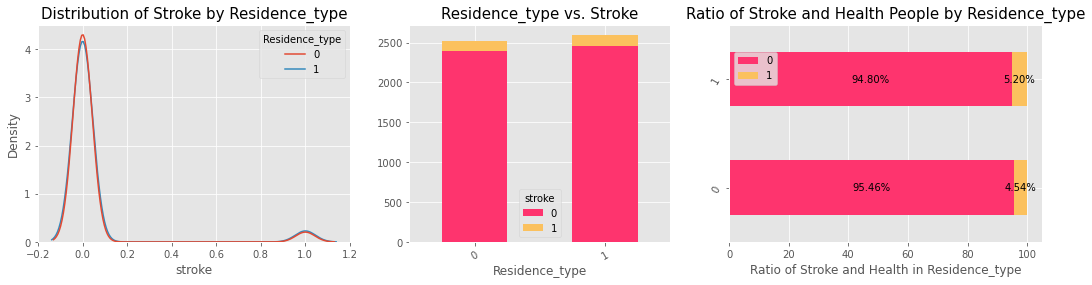

In [1040]:
# How 'residence type' impact the stroke
dis_coun_rat('Residence_type')

ratio_heart_disease = data[(data['stroke']==1) & (data['Residence_type']==0)]['age'].count()/data[(data['stroke']==1) & (data['Residence_type']==1)]['age'].count()
print('\033[1m'+'The chance of people living in urban to suffer stroke are %0.2f higher than that of those who live in rural.' %ratio_heart_disease)

The chance of people with hypertension to suffer stroke are 2.77 higher than that of those without hypertension.


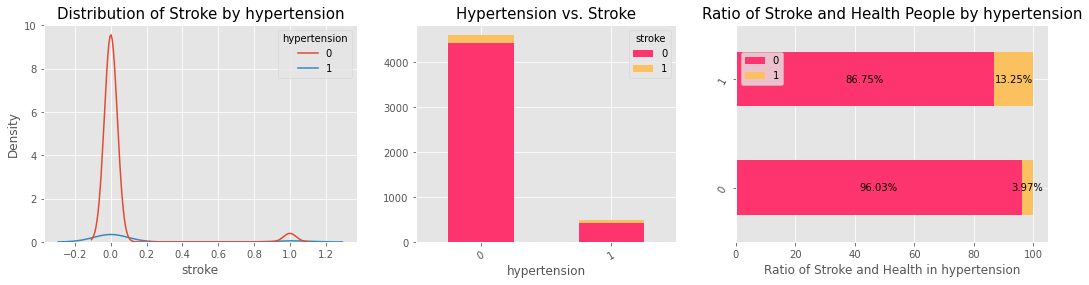

In [1041]:
# How 'hypertension' impact the stroke
dis_coun_rat('hypertension')

ratio_hypertension = data[(data['stroke']==1) & (data['hypertension']==0)]['age'].count()/data[(data['stroke']==1) & (data['hypertension']==1)]['age'].count()
print('\033[1m'+'The chance of people with hypertension to suffer stroke are %0.2f higher than that of those without hypertension.' %ratio_hypertension)

The chance of people with heart disease to suffer stroke are 4.30 higher than that of those without heart disease.


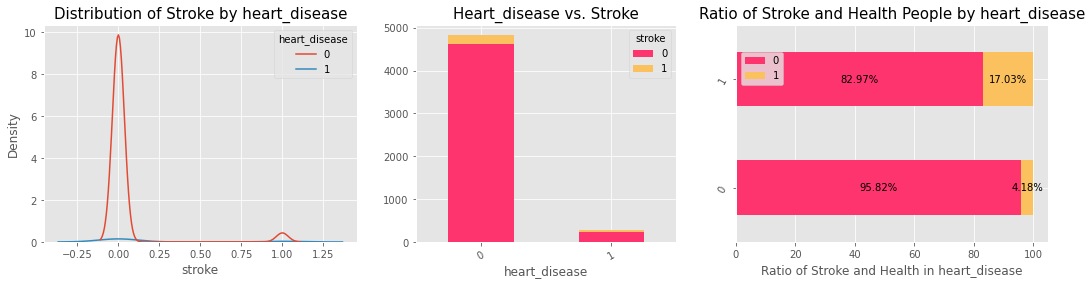

In [1042]:
# How 'heat disease' impact the stroke
dis_coun_rat('heart_disease')

ratio_heart_disease = data[(data['stroke']==1) & (data['heart_disease']==0)]['age'].count()/data[(data['stroke']==1) & (data['heart_disease']==1)]['age'].count()
print('\033[1m'+'The chance of people with heart disease to suffer stroke are %0.2f higher than that of those without heart disease.' %ratio_heart_disease)

#### Categorical Features Summary:
This dataset has 7 categorical features, including 3 categorical features and 4 binary numerical features. Since for 'gender' feature, we only have one such data, so I drop this data and kept the 'female' and 'male' in this feature. Therefore, the final dataset has 7 categorical features, 2 categorical features('work_type','smoking_status') and 5 binary numerical features('gender','ever_married', 'Residence_type', 'hypertension', 'heart_disease', 'stroke').


I analysis these categorical features from **4** aspects: 

- 1) target distbution by detailed categories in every feature(left figure) 


- 2) How the categories impact on the number of target(middel figure)


- 3)The ratio of target in each category(right figure)


- 4) The ratio of target by diverse categories(the bottom print number)


From the above figures ,it can be found:
- **The most influential feature is marriage**. The results shoewed the people who has marriage whether ended or not has **7.59 times higher** than those who never married. 


- The **second** influential feature is if one has **heart disease**. Those who has heart disease showed **4.3 times higher** chances to suffer stroke than who with healthy heart.


- The **third** important feature is **hypertension**. If one has hypertension, he/she has **2.77 times higher** chances to get stroke


- Although smoking status is not as important as the previous ones, it also showed that people who smoke has about 1.24 times higher changes to suffer stroke than those who never smoke.


- One interesting phenomena from these data is **people who never worked almost never suffer stroke**, and 5% of those who worked got stroke.


- Residence type and gender don't show have much influence on stroke. Basically, the probability of getting stroke for people who live in rural is a little higher than those who live in urban. And Female is little higher than male.

<a id='visualization'></a>
### 2.4 Visualization of the correlations between features

In order to quantify correlations between the featuresa and the target,I will calculate Pearson correlation coefficient, which mean the quantitative relationship between two variables. Although there can be non-linear relationships between the features and targets,and correlation coefficients do not account for such interactions, linear relationships are still a good way to start exploring trends in the data. We can use them for selecting the features to employ in the model.

In [1043]:
# Find correlations between features and target, and sort
correlations_data = data.corr()['stroke'].sort_values(ascending = False)

# print the results
print(correlations_data,'\n')

stroke               1.000000
age                  0.245239
heart_disease        0.134905
avg_glucose_level    0.131991
hypertension         0.127891
ever_married         0.108299
bmi                  0.042341
Residence_type       0.015415
gender               0.009081
Name: stroke, dtype: float64 



I firstly checked the corrrelations between all numerical variables and stroke. The result showed that age has the most positive correlations with the stroke. Intuitively, this results make sense: since immunity decreases with the increasement of age.

To account for possible non-linear relationships, I also take the square root and natural log transformation of the continuous features and then calculate the correlation coefficients with the stroke. At the same time, to try and capture any possible relationships between 'smoking_status' or 'work_type'(categorical variables) and the stroke, I will use label encoding to transfer the detailed categories into numbers.

In the following code, I will **take log and square root transformation fo the continuous variables, label-encode the categorical variables**, calculate the correlations between all of the features and stroke.

Text(0.5, 1.0, 'Correlation Map of Features')

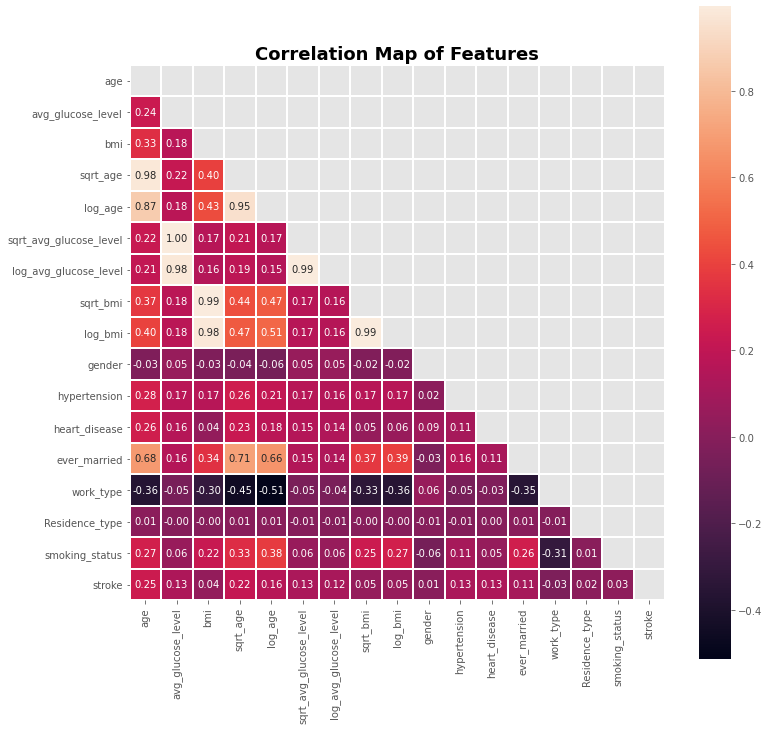

In [1044]:
# Correlation map of features
data2 = data.copy()

# create columns with square root and log of continuous feature
continuous_subset = data2[['age','avg_glucose_level','bmi']]
for col in continuous_subset:
    continuous_subset['sqrt_' + col] = np.sqrt(continuous_subset[col])
    continuous_subset['log_' + col] = np.log(continuous_subset[col])
    
# select the categorical solumns
categorical_subset = ['smoking_status','work_type']

# Label encode the original categorical features
for col in categorical_subset:
    data2[col] = LabelEncoder().fit_transform(data2[col])

# join the two dataframe together
new_features = pd.concat([continuous_subset, data2.drop(['age','avg_glucose_level','bmi'],axis = 1)], axis = 1)

cols = new_features.columns

# normalizing with standard scaler of numerical features
new_features[cols] = StandardScaler().fit_transform(new_features[cols])

# calculate the correlation
data_corr = new_features.corr()
mask = np.triu(np.ones_like(data_corr, dtype=np.bool))

#data_corr = data_corr.iloc[1:,:-1].copy()
#mask = mask[1:, :-1]

# map the correlations between variables
fig, ax = plt.subplots(figsize = (12,12))
sns.heatmap(data_corr,mask=mask,annot = True,linewidth = 1,fmt=".2f", square = True, ax = ax)
ax.set_title('Correlation Map of Features',{ 'size':18, 'weight':'bold'})

In [1045]:
# print the correlation between features and target after the transfering of some features
new_features.corr()['stroke'].sort_values(ascending = False)

stroke                    1.000000
age                       0.245239
sqrt_age                  0.215083
log_age                   0.164872
heart_disease             0.134905
avg_glucose_level         0.131991
hypertension              0.127891
sqrt_avg_glucose_level    0.125348
log_avg_glucose_level     0.117081
ever_married              0.108299
log_bmi                   0.054088
sqrt_bmi                  0.048580
bmi                       0.042341
smoking_status            0.028108
Residence_type            0.015415
gender                    0.009081
work_type                -0.032323
Name: stroke, dtype: float64

<a id='feature'></a>
### 3. Feature Engineering and Selection

<a id='feature_e'></a>
### 3.1 Feature Engineering

I will use the results of the EDA to inform the feature engineering.

From the above results [Part 2.4](#part2.4), it can be found that taking the square root and log transfermation of continuous features don't result in increase in the linear correlations between continuous features and stroke. So I will keep using the original ones and drop the transfermations of continuous forms. At the same time, I have tranfer the categorical features into numerical features by using LabelEncoder.

<a id='feature_s'></a>
### 3.2 Feature Selection

Herein, based on the EDA results and coefficients between features and target, I will only take the following steps for feature selection:
- Select all the continuous features:'age','bmi','avg_glucose_level' 


- Select the numerical variables:'heart_disease', 'hypertension','ever_married'


- Label encode the categorical variables and only keep 'work_type'

Because any model building is the balance between results and time consuming. If the dataset is too large, we can drop theose features that have little influence on the target. And the final results will have no much difference.

In [1074]:
data = data.drop(['gender','smoking_status', 'Residence_type'], axis = 1)

<a id='remove'></a>
### 3.3 Remove the collinear features 

Highly collinear features means there is a significant correlation coefficent between them. Sometimes they are highly correlated just because they are slightly different means of calculating the target. Therefore, not all of these features are likely to be improtant for predicting the target, and some of the features are redundant because they are highly correlated. We only need to retain one of them, which can give the model necessary information. In this project, I will remove features that have a correlation coefficient above a certain threshold with each other.

In [1075]:
# a function that will drop the features whose correlation with other feature is larger than the threshold
def remove_collinear_features(x, threshold):
    
    # Dont remove correlations between the target
    y = x['stroke']
    x = x.drop(columns = ['stroke'])
    
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)
   
    # Add the score back in to the data
    x['stroke'] = y
               
    return x

In [1070]:
final_features = remove_collinear_features(data, 0.6)
final_features.shape

TypeError: 'dict' object is not callable

Herein, our data have no collinear features, so we have no redundant features that need to be remove. Until now, we have finished the EDA, feature engineering and selection (including removing collinear features). We will come to the next split the data and model them.

<a id='split'></a>
## 4. Split dataset and Models Selection

<a id='imputing'></a>
### 4.1 Imputing missing Values

There are many ways to filling missing values, the relatively simple method is to replace missing values with the mean or the median of the column.I will use a simple **decision tree** which based on age,gender,glucose level of all other samples to predict the missing values of bmi.

In [1076]:
# Use related features to predict the missing values in bmi
bmi_pipeline = Pipeline(steps = [('scale', StandardScaler()),('lr', DecisionTreeRegressor(random_state = 42))])
sub_X = data[['age','bmi','avg_glucose_level']].copy()

missing_bmi = sub_X[sub_X['bmi'].isna()]
sub_X = sub_X[sub_X['bmi'].notna()]
Y = sub_X.pop('bmi')
bmi_pipeline.fit(sub_X,Y)
predicted_bmi = pd.Series(bmi_pipeline.predict(missing_bmi[['age','avg_glucose_level']]), index = missing_bmi.index)
data.loc[missing_bmi.index, 'bmi'] = predicted_bmi

<a id='establish'></a>
### 4.2 Establish a baseline
The goal to establish a baseline is to compare the model with the naive guess. For  this imbalanced dataset, I will use the percentage of stroke in dataset: 5% as baseline. So a good target to beat would be 5%. Null Accuracy Score would be 95%.

In [1077]:
print('Inverse of Null Accuracy: ', round(249/(249 + 4861),2))
print('Null Accuracy: ', round(4861/(249 + 4861),2))

Inverse of Null Accuracy:  0.05
Null Accuracy:  0.95


<a id='training'></a>
### 4.3 Training and test Sets

In [1078]:
# training and testing data split
X = data.drop(columns = ['stroke'])
y = data['stroke']

# Since the data are imbalanced, I split the data using stratify to maintain the same percentage in bothing training and tsting set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 42, stratify = y)
print('Train stroke ratio = {:.3f}'.format(y_train.mean()))
print('Test stroke ratio = {:.3f}'.format(y_test.mean()))

Train stroke ratio = 0.049
Test stroke ratio = 0.049


It can be found that the split has maintained the same percentage in both training and testing set.

<a id='deal'></a>
### 4.4 Deal with imbalance data by SMOTE and RandomUnderSampler

The challenge of working with imbalanced datasets is that most machine learning techniques have poor performance on the minority class. One approach to addresing this is to oversample the minority, which can be achieved by synthetic minority oversampling technique (**SMOTE**). 

To better solve the imbalance problem, I will use **SMOTE** to oversampe the minority calss to have 30% the number of examples of the majority class(about 2000), then use **RandomUnderSampler** to reduce the number of examples in the majority class to have 50% more than the minority class(about 4000).

In [1079]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#oversample = SMOTE()
oversample = SMOTE(sampling_strategy = 0.4)
undersample = RandomUnderSampler(sampling_strategy = 0.5)

# chain the two transforms together into a pipeline
steps = [('o', oversample),('u',undersample)]
pipeline = Pipeline(steps = steps)

# transform the dataset
x_train_resample, y_train_resample = pipeline.fit_resample(x_train, y_train)

print('The original x_train has \033[1m{}\033[0m data, and its corresponding stroke ratio is \033[1m{}\033[0m.'.format(x_train.shape[0],round(data['stroke'].sum()/data['stroke'].count(),2)))
print('The x_train_resample after resampling has \033[1m{}\033[0m data, and the stroke ratio after resampling is \033[1m{}\033[0m.'.format(x_train_resample.shape[0], round(y_resample[y_resample == 1].sum() / y_resample.shape[0], 2)))

ValueError: could not convert string to float: 'Yes'

To avoid the effect of different range of features, I scaled the features firstly.

<a id='models'></a>
### 4.5 Models comparison

I will compare five different machine learning models using sklearn:
- 1.Logistic Regression
- 2.SVM
- 3.Decision Tree
- 4.Random Forest
- 5.Gradient Boosting

In [1061]:
# define the function to predict the test and get the metric score
def predictions(x_set, y_set, x_test):
    # To avoid the effect of different range of features, I scaled the features firstly.
    # Create the scaler object with a range of 0-1
    scaler = MinMaxScaler(feature_range=(0, 1))
        
    # Fit on the training data
    scaler.fit(x_set)

    # Transform both the training and testing data
    x_set = scaler.transform(x_set)
    x_test = scaler.transform(x_test)
    
    accuracy, precision, recall, f1, roc_auc, conf_mat = [],[],[],[],[],[]
    
    classifiers = []
    classifiers.append(LogisticRegression(random_state = 42))
    classifiers.append(SVC(random_state=42, probability = True))
    classifiers.append(DecisionTreeClassifier(random_state= 42))
    classifiers.append(RandomForestClassifier(random_state = 42))
    classifiers.append(GradientBoostingClassifier(random_state = 42))   
    
    for classifier in classifiers:       
        clf = classifier
        #fit 
        clf.fit(x_set,y_set)
        # predict
        y_preds = clf.predict(x_test)
        y_probs = clf.predict_proba(x_test)
        #metrics
        accuracy.append(round(accuracy_score(y_test,y_preds),3))
        precision.append(round(precision_score(y_test,y_preds),3))
        recall.append(round(recall_score(y_test,y_preds),3))
        f1.append(round(f1_score(y_test,y_preds),3))
        roc_auc.append(round(roc_auc_score(y_test,y_probs[:,1]),3))
        conf_mat.append(confusion_matrix(y_test,y_preds))      
    
    results_df = pd.DataFrame({"Algorithm":["LogisticRegression","SVC","DecisionTree","RandomForest","GradientBoosting"],"Accuracy Score":accuracy,"Precision Score":precision,
                        "Recall Score":recall, "f1 Score":f1,"Roc-auc Score":roc_auc,
                        "Confusion Matrix":conf_mat})
    results_df = results_df.set_index('Algorithm')
    return results_df

In [1062]:
# First calculate the origical data(before resampling)
original_results = predictions(x_train, y_train,x_test)
original_results

ValueError: could not convert string to float: 'Private'

In [850]:
resample_results = predictions(x_train_resample,y_train_resample,x_test)
resample_results

,Accuracy Score,Precision Score,Recall Score,f1 Score,Roc-auc Score,Confusion Matrix
Algorithm,,,,,,
LogisticRegression,0.856,0.169,0.493,0.252,0.774,"[[1276, 182], [38, 37]]"
SVC,0.850,0.111,0.293,0.161,0.741,"[[1281, 177], [53, 22]]"
DecisionTree,0.868,0.124,0.280,0.172,0.589,"[[1310, 148], [54, 21]]"
RandomForest,0.902,0.172,0.267,0.209,0.771,"[[1362, 96], [55, 20]]"
GradientBoosting,0.870,0.127,0.280,0.174,0.774,"[[1313, 145], [54, 21]]"


Text(0.5, 1.0, 'Model Comparison')

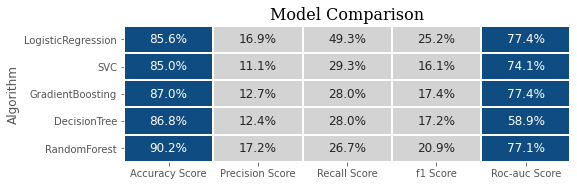

In [857]:
# Print the table and highlight the values that > 50%
fig, ax = plt.subplots(figsize = (8,2.5))
model_metric_score = sns.heatmap(resample_results.drop(['Confusion Matrix'],axis=1).sort_values(by=['Recall Score','f1 Score'],ascending = False), cmap = ["lightgray","#0f4c81"], annot=True,fmt=".1%",linewidths=1,cbar = False, annot_kws={"fontsize":12})
model_metric_score
plt.title('Model Comparison',fontsize = 16, fontfamily = 'serif')

#### Imbalanced data and model selections summary:
It can be seen that resampling data showed better predictions scores than original data. 


And among all the models, **LogisticRegression** showed  higher **f1**, recall, and roc_auc scores, although its accuracy score is not the highest. And GradientBoosting is the second. 


Since in this case, what I really care is if one will have a stroke, I would firstly select the models with the higher recall and f1 scores to perform the following hyperparameter tuning to obtain the best model.

<a id='perform'></a>
## 5. Perform Hyperparameter Tuning on Best Models

<a id='hyper'></a>
### 5.1 Hyperparameter tuning of the logisticregression model

Here I will use **GridSearch and CrossValidation** to perform LogisticRegression' hyperparameter tuning. 

In [982]:
# First scale the feature to be in the same range
scaler = MinMaxScaler(feature_range=(0, 1))
        
# Fit on the training data
scaler.fit(x_train_resample)

# Transform both the training and testing data
x_train_resample = scaler.transform(x_train_resample)
x_test = scaler.transform(x_test)

In [992]:
# Combine cross validation with grid search or random search to find the best parameters
lg_clf = LogisticRegression(random_state=42)

C = [0.05, 0.1, 1, 5] 
solver = ['liblinear', 'sag', 'saga']
max_iter = [100, 200, 500, 700, 1000]
log_param_grid = {'C': C, 'solver':solver,'max_iter':max_iter}

grid = GridSearchCV(lg_clf,log_param_grid,scoring = 'recall')

In [993]:
# fit and find the found the best parameters
grid.fit(x_train_resample,y_train_resample)
grid.best_params_

{'C': 5, 'max_iter': 100, 'solver': 'liblinear'}

In [994]:
# comparison of the metric scores of LogisticRegression before and after tune
# Apply the best params to the model
tuned = LogisticRegression(solver='liblinear', C=5, max_iter=100, random_state=42)
tuned.fit(x_train_resample, y_train_resample)
y_pred_tuned = tuned.predict(x_test)

not_tuned = LogisticRegression(penalty='none', max_iter=5000, random_state=42)
not_tuned.fit(x_train_resample, y_train_resample)
y_pred_not_tuned = not_tuned.predict(x_test)

data = {
    'accuracy': [round(accuracy_score(y_test, y_pred_tuned),3), round(accuracy_score(y_test,logreg_tuned_pred),3)],
    'precision': [round(precision_score(y_test, y_pred_tuned),3), round(precision_score(y_test,logreg_tuned_pred),3)],
    'recall': [round(recall_score(y_test, y_pred_tuned),3), round(recall_score(y_test,logreg_tuned_pred),3)],
    'f1 score': [round(f1_score(y_test, y_pred_tuned),3), round(f1_score(y_test,logreg_tuned_pred),3)]
}
pd.DataFrame.from_dict(data, orient='index', columns=['tuned', 'not tuned'])

,tuned,not tuned
accuracy,0.855,0.856
precision,0.167,0.168
recall,0.493,0.493
f1 score,0.249,0.251


<a id='hyperp'></a>
### 5.2 Hyperparameter tuning of the GradientBoosting model

Here I will use **RandomizedSearch and CrossValidation** together to tune the gradient boosting models. Different from the grid search which evaluates every single combination we specify, random search refers to the method in which we choose hyperparameters to evaluate: we define a range of options, and then randomly select combinations to try. This is better and faster when we have limited knowledge of the best model hyperparameters and we can use random search to narrow down the options and then use grid search with a more limited range of options.

In [995]:
# Number of trees used in the boosting process
n_estimators = [100, 200, 300, 500]

# Maximum depth of each tree
max_depth = [3, 5, 7]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6]

# Maximum number of features to consider for making splits
max_features = ['sqrt'，None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [996]:
# Create the model to use for hyperparameter tuning
model = GradientBoostingClassifier(random_state = 42)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=5, n_iter=25, 
                               scoring = 'recall',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

# Fit on the training data
random_cv.fit(x_train_resample, y_train_resample)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


C:\Users\xiaoj\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.82941176        nan 0.83455882 0.84411765 0.84338235 0.90220588
 0.82205882 0.88235294        nan 0.84338235        nan 0.90808824
 0.82058824        nan 0.80882353 0.90367647 0.88161765        nan
        nan 0.87279412 0.81544118 0.90147059 0.83602941 0.81544118
 0.81544118]
  warnings.warn(
C:\Users\xiaoj\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the train scores are non-finite: [0.88143382        nan 0.90257353 0.93253676 0.89099265 1.
 0.90110294 0.990625          nan 0.89099265        nan 1.
 0.89485294        nan 0.85422794 1.         0.996875          nan
        nan 0.99889706 0.85514706 1.         0.89761029 0.86433824
 0.86433824]
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 5, 10, 15],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [1, 2, 4, 6, 10],
                                        'n_estimators': [50, 100, 200, 300, 500,
                                                         600]},
                   random_state=42, return_train_score=True, scoring='recall',
                   verbose=1)

In [997]:
random_cv.best_estimator_

GradientBoostingClassifier(max_depth=15, min_samples_leaf=4, n_estimators=300,
                           random_state=42)

In [1007]:
# comparison of the metric scores of GradientBoosting before and after tune
tuned = GradientBoostingClassifier(max_depth=3, 
                           min_samples_leaf=1, min_samples_split=2,
                           n_estimators=100, random_state=42)
not_tuned = GradientBoostingClassifier(random_state=42,)

# fit
tuned.fit(x_train_resample, y_train_resample)
not_tuned.fit(x_train_resample, y_train_resample)

# prediction
y_pred_tuned = tuned.predict(x_test)
y_pred_not_tuned = not_tuned.predict(x_test)

# list the metric scores
data = {
    'accuracy': [accuracy_score(y_test, y_pred_tuned), accuracy_score(y_test, y_pred_not_tuned)],
    'precision': [precision_score(y_test, y_pred_tuned), precision_score(y_test, y_pred_not_tuned)],
    'recall': [recall_score(y_test, y_pred_tuned), recall_score(y_test, y_pred_not_tuned)],
    'f1 score': [f1_score(y_test, y_pred_tuned), f1_score(y_test, y_pred_not_tuned)]
}
pd.DataFrame.from_dict(data, orient='index', columns=['tuned', 'not tuned'])

,tuned,not tuned
accuracy,0.870189,0.870189
precision,0.126506,0.126506
recall,0.280000,0.280000
f1 score,0.174274,0.174274


In [1011]:
# defining parameter range 
svm_param_grid = {'C': [0.1,1, 5, 100],  
            'gamma': ['scale','auto'], 
           'kernel': ['rbf','poly','sigmoid'],
                 'max_iter':[-1, 5,10,100]} 

svm = SVC(random_state=42)

grid = GridSearchCV(svm,svm_param_grid,scoring='recall')

grid.fit(x_train_resample, y_train_resample)

GridSearchCV(estimator=SVC(random_state=42),
             param_grid={'C': [1, 5, 100, 1000, 2000],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='recall')

In [1014]:
grid.best_estimator_

SVC(C=2000, random_state=42)

In [1013]:
# Let's use those params now
tuned = SVC(C=1, random_state=42)
not_tuned = SVC(random_state=42)

tuned.fit(x_train_resample, y_train_resample)
not_tuned.fit(x_train_resample, y_train_resample)

y_pred_tuned = tuned.predict(x_test)
y_pred_not_tuned = not_tuned.predict(x_test)

# list the metric scores
data = {
    'accuracy': [accuracy_score(y_test, y_pred_tuned), accuracy_score(y_test, y_pred_not_tuned)],
    'precision': [precision_score(y_test, y_pred_tuned), precision_score(y_test, y_pred_not_tuned)],
    'recall': [recall_score(y_test, y_pred_tuned), recall_score(y_test, y_pred_not_tuned)],
    'f1 score': [f1_score(y_test, y_pred_tuned), f1_score(y_test, y_pred_not_tuned)]
}
pd.DataFrame.from_dict(data, orient='index', columns=['tuned', 'not tuned'])

,tuned,not tuned
accuracy,0.849967,0.849967
precision,0.110553,0.110553
recall,0.293333,0.293333
f1 score,0.160584,0.160584


In [906]:
confusion_matrix(y_test,y_pred_tuned )

array([[1267,  191],
       [  55,   20]], dtype=int64)

<a id='hyperpa'></a>
### 5.3 Hyperparameter tuning of SVM model and evaluation
So all of models I tried here have a good accuracy, and the highest . In this case, I assume it would be to offer medical advice or preventative treatment to those predicted will have a stroke, therefore, I would select the model with the highest recall and f1 scores.

<a id='conclusion'></a>
## 6. Conclusion

In this project, after getting the basic information, I performed the **EDA** of the data and found that **the bata is imbalanced**. Then I analysed distribution of all features and their effects on the target-'stroke'. 

Based on the correlations between the features and the EDA results, I also performed **feature engineering and selection**. I also checked if there are any **collinear features**.(In this case, there is no collinear features). 

Then before diving into the models, I firstly **imputed the missing values**, dealed with the imbalanced data with SMOTE and RandomUnderSample. Then I tried 5 models: **Logisticregression, SVM,decision tree, random forest and gradient boosting**. After inital fitting and prediction, I found that Logisticregression work best since its recall and f1 scores are highest. Although its accuracy scores are not the highest, here we focus on if one will have stroke and I will perfer 'recall' and 'f1' score instead of accuracy score as the metric scores. Lastly I further performed hyperparameter tuning on the models.